In [23]:
# Fig4 and Fig S11
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()
C_ATC = [0 ,10 ,20,40 ,60 ,80 ,100 ,150 ,250 ,500 ,750,1000]

In [25]:
def fold_change(lkns, el, gama,c, K=1):
    
    pref= 1/lkns -1
    numeratorfc = 1+np.exp(-el-gama)*((c/K)**2)
    denomenatorfc = 1+np.exp(-el)*((c/K)**2)
    
    FC = 1/(1+pref*numeratorfc/denomenatorfc)
    return FC

In [5]:
# the inferred 1000 posterior samples (el,gama,sigma) for each mutant, taken from 1 million MC samples
with open('Inferred_Post_Samples.txt','r') as f: 
    alllines=f.readlines()
Post_Samples=[]
for each in alllines[2::2]:
    Temp=[]
    for eac in each[2:-3].split('], ['):
        temp=[]
        for ea in eac.split(','):
            temp.append(float(ea))
        Temp.append(temp)
    Post_Samples.append(Temp[1:1001])
print(np.shape(Post_Samples))

(23, 1000, 3)


In [6]:
# experimental leakiness of each mutant and the corresponding sem
with open('leak_info.txt','r') as g:
    alllines=g.readlines()[0][2:-2]
    
temp_leakraw, Leakns_read =alllines.split('], ['), []
for each in temp_leakraw:
    tplkr, templ =each.split(','), []
    for eac in tplkr: templ.append(float(eac))
    Leakns_read.append(templ)
print(np.shape(Leakns_read))

(23, 2)


In [8]:
def check_parainfer(lkinfo, paraminfered,percentile):
    perc=1-percentile
    
    ed= -np.log(1/lkinfo[0]-1) + np.log(1/leakWT-1)
    edl=-np.log(1/(lkinfo[0]-lkinfo[1])-1) + np.log(1/leakWT-1)
    edh=-np.log(1/(lkinfo[0]+lkinfo[1])-1) + np.log(1/leakWT-1)
        
    parainfered_el, parainfered_gama, parainfered_sigma = [],[],[]

    for i in range(len(paraminfered)):
        parainfered_el.append(paraminfered[i][0])
        parainfered_gama.append(paraminfered[i][1])
        parainfered_sigma.append(paraminfered[i][2])

    parainfered_el=np.sort(parainfered_el)
    parainfered_gama=np.sort(parainfered_gama)
    parainfered_sigma=np.sort(parainfered_sigma)
    
    median2 = [ [ed,edl,edh],
               [np.median(parainfered_el),parainfered_el[round(len(paraminfered)*perc/2)],parainfered_el[-round(len(paraminfered)*perc/2)]],
               [np.median(parainfered_gama),parainfered_gama[round(len(paraminfered)*perc/2)],parainfered_gama[-round(len(paraminfered)*perc/2)]],
             [np.median(parainfered_sigma),parainfered_sigma[round(len(paraminfered)*perc/2)],parainfered_sigma[-round(len(paraminfered)*perc/2)]]]
    return median2

In [12]:
leakWT=Leakns_read[-1][0]
para_WT = Parameters[-1]
print(leakWT)

0.008603896474187292


In [13]:
Parameters = []
for i in range(23): 
    Parameters.append(check_parainfer(Leakns_read[i], Post_Samples[i], 0.95))
print(np.shape(Parameters))

(23, 4, 3)


In [96]:
def goodness_of_fit_comb(postsamp_comb,mut1data,mut1n,mut2data,mut2n,DATA4,name,bbx,wts,ncl,limyh=1.2,limyl=-0.2, yticks=np.arange(-0.2,1.21,0.2)):
    mc_step=len(postsamp_comb)
    
    Us=[] 
    for each in postsamp_comb:
        tempu=[]
        for c in C_ATC:
            tempu.append(fold_change(each[0],each[1],each[2],c))
        Us.append(tempu)
    print(np.shape(Us))
    
    fc_predict_12=[]
    for i in range(12):
        temp = np.asarray(Us)[:,i].copy()
        temp.sort()
        fc_predict_12.append(temp)
    
    # next, plot the predictive fold change from the infered 4001 sets of param
    fc_median=[]
    fc_up95,fc_low95=[],[]
        
    for i in range(12):
        fc_median.append(np.median(fc_predict_12[i]))
        fc_up95.append(fc_predict_12[i][round(mc_step*0.05/2)])
        fc_low95.append(fc_predict_12[i][-round(mc_step*0.05/2)])

    FC_pred_plot = plt.figure(figsize=(8,6))  # Fold-change predict plot
    fcpred = FC_pred_plot.add_subplot(1,1,1)
    
    color1,color2,color3,color4,color5,color6,color7 = 'darkblue','royalblue','steelblue','cornflowerblue','skyblue','lightskyblue','lightsteelblue'
    fcpred.fill_between(C_ATC, fc_up95, fc_low95, alpha=1,color=color3)
        
    L1=len(mut1data[0])
    fcpred.plot(C_ATC[:L1],mut1data[0],'o', mfc='orange',mec='black',mew=1,markersize=8,label=mut1n)    
    for m in range(1,len(mut1data)-1):
        Lm = len(mut1data[m])
        fcpred.plot(C_ATC[:Lm],mut1data[m][:Lm],'o', mfc='orange',mec='black',mew=1,markersize=8)
        
    L1=len(mut2data[0])
    fcpred.plot(C_ATC[:L1],mut2data[0],'o', mfc='black',mec='black',mew=1,markersize=8,label=mut2n)  
    for m in range(1,len(mut2data)-1):
        Lm = len(mut2data[m])
        fcpred.plot(C_ATC[:Lm],mut2data[m][:Lm],'o', mfc='black',mec='black',mew=1,markersize=8)
        
    L1=len(DATA4[0])
    fcpred.plot(C_ATC[:L1],DATA4[0],'o', mfc='white',mec='black',mew=1,markersize=8,label='data')
    for m in range(1,len(DATA4)-1):
        Lm = len(DATA4[m])
        fcpred.plot(C_ATC[:Lm],DATA4[m][:Lm],'o', mfc='white',mec='black',mew=1,markersize=8)    
            
    fcpred.tick_params(labelsize=36) # make ticks bigger
    fcpred.set_ylim([limyl, limyh])
    fcpred.set_xlim([-1, 1300])
    fcpred.set_yticks(yticks)
    fcpred.set_ylabel('Fold Change', fontsize = 36)
    fcpred.set_xlabel('Ligand Concentration (nM)', fontsize = 36)
    fcpred.legend( loc=bbx, ncol=ncl,fontsize=36,frameon=False,handletextpad=-0.5,markerscale=1.5)
    fcpred.set_title(name, fontsize = 36)
    fcpred.set_xscale('symlog',linthresh=10)
    FC_pred_plot.savefig('New_Figures/{0:}_{1:}_comb_FC_fit.png'.format(name,str(wts)),dpi=300,bbox_inches='tight',pad_inches=0.01)
    FC_pred_plot.savefig('New_Figures/{0:}_{1:}_comb_FC_fit.pdf'.format(name,str(wts)),dpi=300,bbox_inches='tight',pad_inches=0.01)

    

In [47]:
Parameters[1]

[[1.111154815871926, 1.0894707401137524, 1.132401822347207],
 [4.514638024392392, 4.27132695198962, 4.74181697569135],
 [6.945220818227175, 5.889394553821639, 10.232606513787388],
 [0.09649599174914139, 0.07910264454309451, 0.12258522954981316]]

In [70]:
def comb_mut(postsamp1, postsamp2, paramut1, paramut2, mut1data,mut1n,mut2data,mut2n,predata,namec,bbx,a1,a2,b1,b2,c1,c2,ncl=1):
    delta_ed = a1*paramut1[0][0] + a2*paramut2[0][0]
    elc = paramut1[1][0]+paramut2[1][0]-para_WT[1][0]
    gamac = paramut1[2][0]+paramut2[2][0]-para_WT[2][0]
    print(delta_ed, elc, gamac)
    
    prefWT = 1/Leakns_read[-1][0]-1
    prefc = prefWT*np.exp(-delta_ed)
    lkc= 1/(1+prefc)
    
    postsample_comb=[]
    for each in postsamp1:
        for eac in postsamp2:
            elc = b1*(each[0]-para_WT[1][0])+b2*(eac[0]-para_WT[1][0])+para_WT[1][0]
            gamac = c1*(each[1]-para_WT[2][0])+c2*(eac[1]-para_WT[2][0])+para_WT[2][0]
            postsample_comb.append([lkc,elc,gamac])
        
    goodness_of_fit_comb(postsample_comb, mut1data,mut1n,mut2data,mut2n,predata, namec,bbx,[a1,a2,b1,b2,c1,c2],ncl)

In [49]:
FCs_read = []
with open('FCdata.txt','r') as g: fclines=g.readlines()[0].split('$')[1:-1]
for each in fclines:
    tempfc=[]
    for eac in each[2:-2].split('], ['):
        tpfc=[float(ea) for ea in eac.split(',')]
        tempfc.append(tpfc)
    FCs_read.append(tempfc)
print(len(FCs_read))

23


In [50]:
Post_mutname=[ 'Y132A', 'C203V', 'D53H', 'P176N_I174K_F177S',
               'R49G',  'P105M', 'G143M','E150Y', 'Q32A_E147G',      
               'G102D_K98Q', 'G102D_L146A', 'G102D_T26A', 'G102D_H44F_Q47S_Q76K', 'G102D_Y42M_I57N', 
              
               'Y132A_G102D_T26A', 'Y132A_PIF', 'Y132A_R49G', 'Y132A_C203V',
               'C203V_D53H',       'C203V_R49G','C203V_PIF',  'C203V_G102D_L146A', 'WT']
print(len(Post_mutname))

23


### Plots in Fig.4 and Fig.S11

1.7934140386177986 0.25043524476000734 7.886075207837235
(1000000, 12)


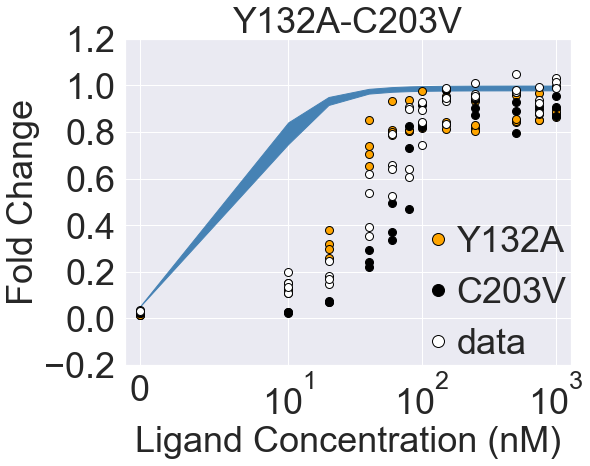

In [63]:
comb_mut(Post_Samples[0], Post_Samples[1], Parameters[0],Parameters[1], FCs_read[0],'Y132A', FCs_read[1][1:],'C203V', FCs_read[-6], 'Y132A-C203V',[0.59,-0.03],1,1,1,1,1,1)


1.7934140386177986 0.25043524476000734 7.886075207837235
(1000000, 12)


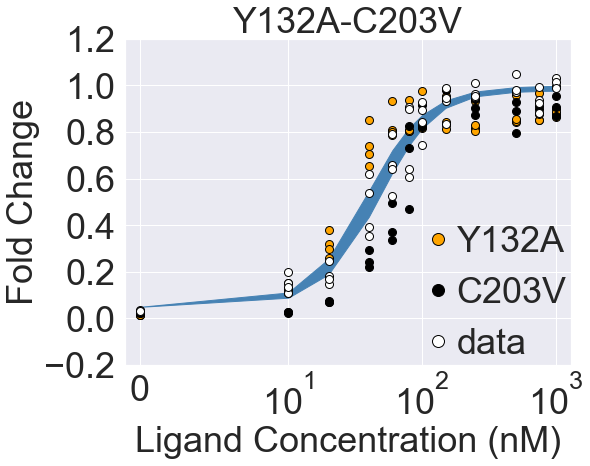

In [64]:
comb_mut(Post_Samples[0], Post_Samples[1], Parameters[0],Parameters[1], FCs_read[0],'Y132A', FCs_read[1][1:],'C203V', FCs_read[-6], 'Y132A-C203V',[0.59,-0.03],1,1,0,1,1,1)


1.2500395891987308 6.790208630922166 2.478407122833686
(1000000, 12)


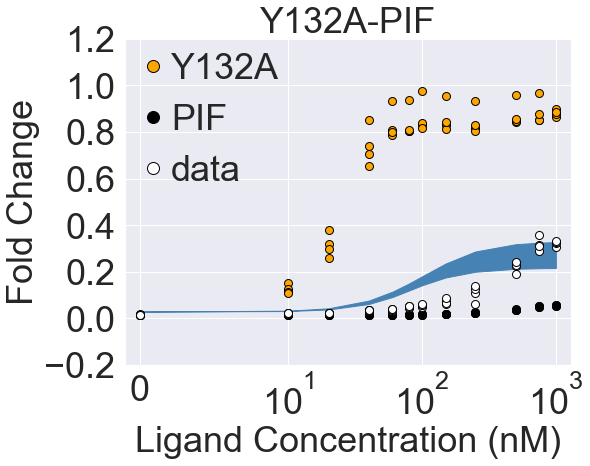

In [62]:
comb_mut(Post_Samples[0], Post_Samples[3], Parameters[0],Parameters[3], FCs_read[0],'Y132A', FCs_read[3],'PIF', FCs_read[-8], 'Y132A-PIF',[-0.05,0.5],1,1,1,1,1,1)


1.2500395891987308 6.790208630922166 2.478407122833686
(1000000, 12)


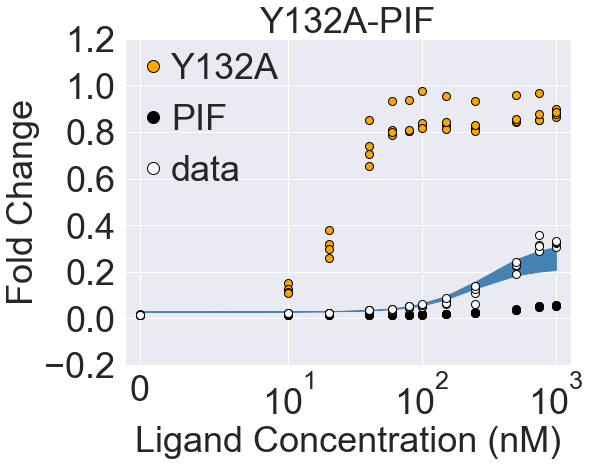

In [61]:
comb_mut(Post_Samples[0], Post_Samples[3], Parameters[0],Parameters[3], FCs_read[0],'Y132A', FCs_read[3],'PIF', FCs_read[-8], 'Y132A-PIF',[-0.05,0.5],1,1,0.5,1,1,1)


1.3518893152818245 4.3541703810798325 2.599391050726549
(1000000, 12)


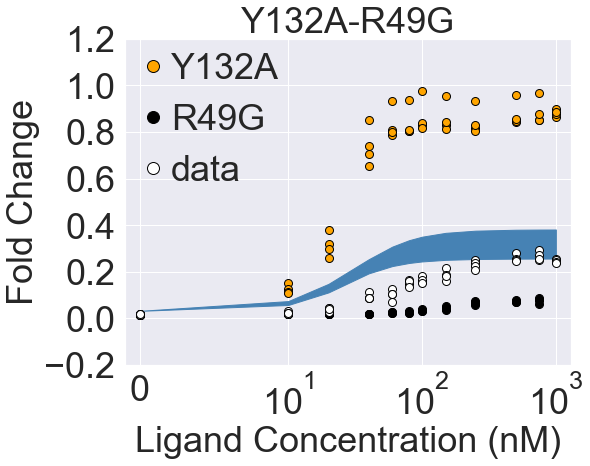

In [65]:
comb_mut(Post_Samples[0], Post_Samples[4], Parameters[0],Parameters[4], FCs_read[0],'Y132A', np.asarray(FCs_read[4])[:,:-1],'R49G', FCs_read[-7], 'Y132A-R49G',[-0.05,0.5],1,1,1,1,1,1)


1.3518893152818245 4.3541703810798325 2.599391050726549
(1000000, 12)


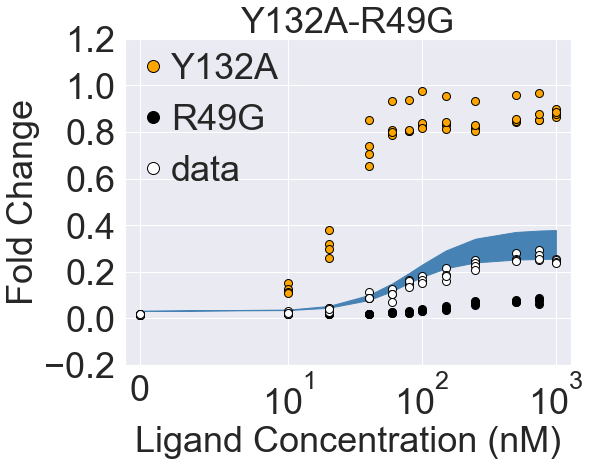

In [66]:
comb_mut(Post_Samples[0], Post_Samples[4], Parameters[0],Parameters[4], FCs_read[0],'Y132A', np.asarray(FCs_read[4])[:,:-1],'R49G', FCs_read[-7], 'Y132A-R49G',[-0.05,0.5],1,1,0.5,1,1,1)


1.6789351823247842 8.954817961046363 3.1976934472917335
(1000000, 12)


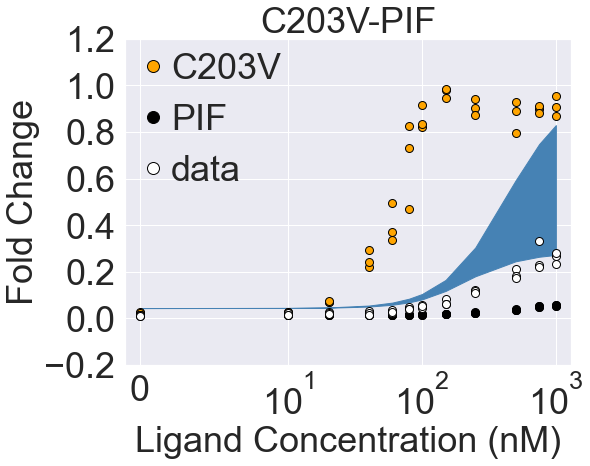

In [74]:
comb_mut(Post_Samples[1], Post_Samples[3], Parameters[1],Parameters[3], FCs_read[1][1:],'C203V', FCs_read[3],'PIF', FCs_read[-3][:-1], 'C203V-PIF',[-0.05,0.5],1,1,1,1,1,1)


0.5677803664528582 8.954817961046363 3.1976934472917335
(1000000, 12)


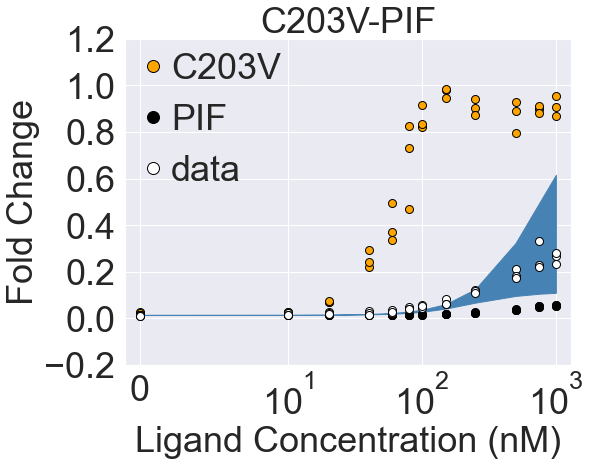

In [75]:
comb_mut(Post_Samples[1], Post_Samples[3], Parameters[1],Parameters[3], FCs_read[1][1:],'C203V', FCs_read[3],'PIF', FCs_read[-3][:-1], 'C203V-PIF',[-0.05,0.5],0,1,1,1,1,1)


1.780784908407878 6.518779711204029 3.3186773751845973
(1000000, 12)


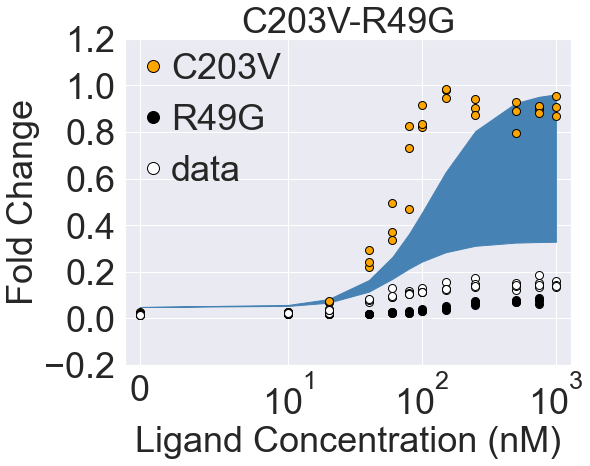

In [76]:
comb_mut(Post_Samples[1], Post_Samples[4], Parameters[1],Parameters[4], FCs_read[1][1:],'C203V', np.asarray(FCs_read[4])[:,:-1],'R49G', FCs_read[-4], 'C203V-R49G',[-0.05,0.5],1,1,1,1,1,1)


0.669630092535952 6.518779711204029 3.3186773751845973
(1000000, 12)


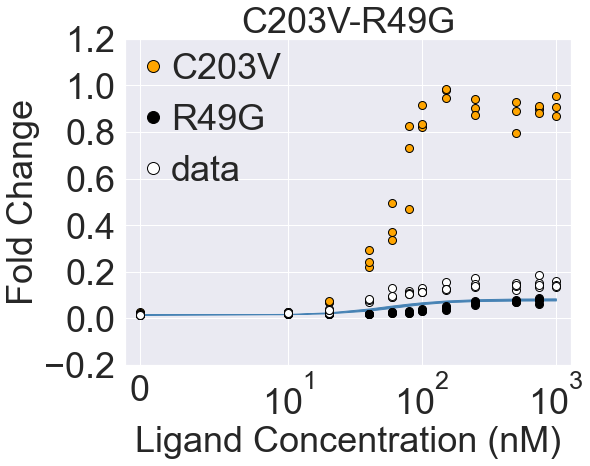

In [77]:
comb_mut(Post_Samples[1], Post_Samples[4], Parameters[1],Parameters[4], FCs_read[1][1:],'C203V', np.asarray(FCs_read[4])[:,:-1],'R49G', FCs_read[-4], 'C203V-R49G',[-0.05,0.5],0,1,1,1,0,1)


1.8334218835978482 3.3596213261791235 3.2755744919146643
(1000000, 12)


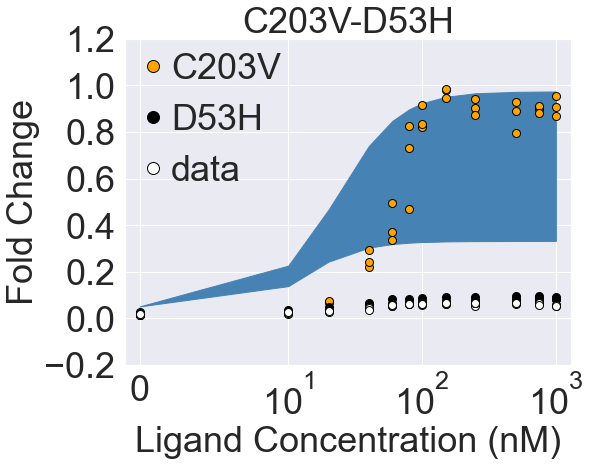

In [78]:
comb_mut(Post_Samples[1], Post_Samples[2], Parameters[1],Parameters[2], FCs_read[1][1:],'C203V', FCs_read[2],'D53H', FCs_read[-5], 'C203V-D53H',[-0.05,0.5],1,1,1,1,1,1)


0.7222670677259222 3.3596213261791235 3.2755744919146643
(1000000, 12)


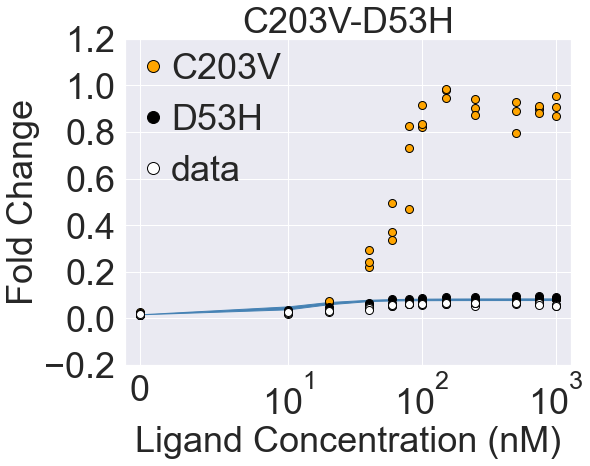

In [79]:
comb_mut(Post_Samples[1], Post_Samples[2], Parameters[1],Parameters[2], FCs_read[1][1:],'C203V', FCs_read[2],'D53H', FCs_read[-5], 'C203V-D53H',[-0.05,0.5],0,1,1,1,0,1)


2.734086347783594 3.598417524535634 7.0857384117619855
(1000000, 12)


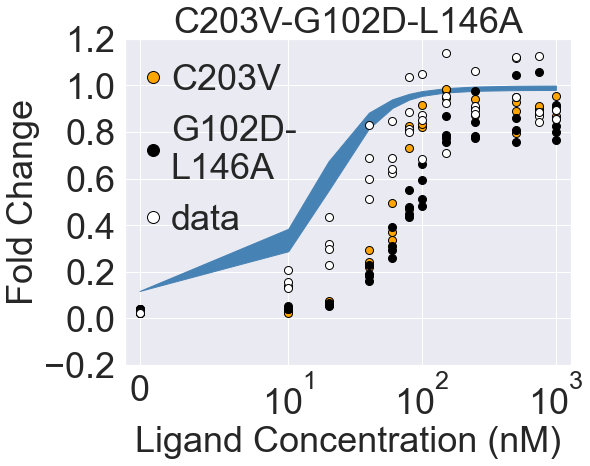

In [87]:
comb_mut(Post_Samples[1], Post_Samples[10], Parameters[1],Parameters[10], FCs_read[1][1:],'C203V', FCs_read[10],'G102D-\nL146A', FCs_read[-2], 'C203V-G102D-L146A',[-0.05,0.35],1,1,1,1,1,1)


1.622931531911668 3.598417524535634 7.0857384117619855
(1000000, 12)


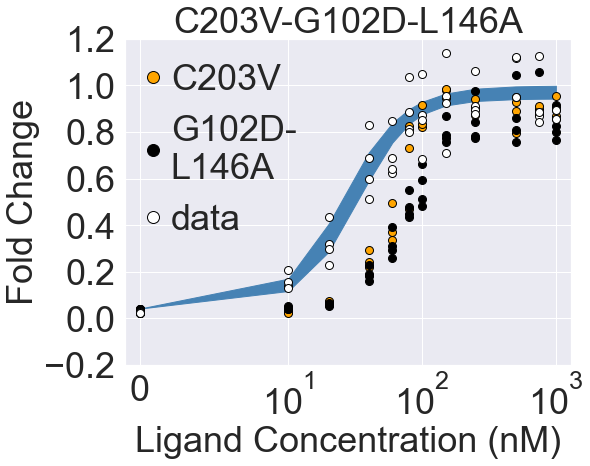

In [97]:
comb_mut(Post_Samples[1], Post_Samples[10], Parameters[1],Parameters[10], FCs_read[1][1:],'C203V', FCs_read[10],'G102D-\nL146A', FCs_read[-2], 'C203V-G102D-L146A',[-0.05,0.35],0,1,1,1,1,1)


In [106]:
def goodness_of_fit_comb(postsamp_comb,mut1data,mut1n,mut2data,mut2n,DATA4,name,bbx,wts,ncl,limyh=1.2,limyl=-0.2, yticks=np.arange(-0.2,1.21,0.2)):
    mc_step=len(postsamp_comb)
    
    Us=[] 
    for each in postsamp_comb:
        tempu=[]
        for c in C_ATC:
            tempu.append(fold_change(each[0],each[1],each[2],c))
        Us.append(tempu)
    print(np.shape(Us))
    
    fc_predict_12=[]
    for i in range(12):
        temp = np.asarray(Us)[:,i].copy()
        temp.sort()
        fc_predict_12.append(temp)
    
    # next, plot the predictive fold change from the infered 4001 sets of param
    fc_median=[]
    fc_up95,fc_low95=[],[]
        
    for i in range(12):
        fc_median.append(np.median(fc_predict_12[i]))
        fc_up95.append(fc_predict_12[i][round(mc_step*0.05/2)])
        fc_low95.append(fc_predict_12[i][-round(mc_step*0.05/2)])

    FC_pred_plot = plt.figure(figsize=(8,6))  # Fold-change predict plot
    fcpred = FC_pred_plot.add_subplot(1,1,1)
    
    color1,color2,color3,color4,color5,color6,color7 = 'darkblue','royalblue','steelblue','cornflowerblue','skyblue','lightskyblue','lightsteelblue'
    fcpred.fill_between(C_ATC, fc_up95, fc_low95, alpha=1,color=color3)
        
    L1=len(mut1data[0])
    fcpred.plot(C_ATC[:L1],mut1data[0],'o', mfc='orange',mec='black',mew=1,markersize=8,label=mut1n)    
    for m in range(1,len(mut1data)-1):
        Lm = len(mut1data[m])
        fcpred.plot(C_ATC[:Lm],mut1data[m][:Lm],'o', mfc='orange',mec='black',mew=1,markersize=8)
        
    L1=len(DATA4[0])
    fcpred.plot(C_ATC[:L1],DATA4[0],'o', mfc='white',mec='black',mew=1,markersize=8,label='data')
    for m in range(1,len(DATA4)-1):
        Lm = len(DATA4[m])
        fcpred.plot(C_ATC[:Lm],DATA4[m][:Lm],'o', mfc='white',mec='black',mew=1,markersize=8)    
        
    L1=len(mut2data[0])
    fcpred.plot(C_ATC[:L1],mut2data[0],'o', mfc='black',mec='black',mew=1,markersize=8,label=mut2n)  
    for m in range(1,len(mut2data)-1):
        Lm = len(mut2data[m])
        fcpred.plot(C_ATC[:Lm],mut2data[m][:Lm],'o', mfc='black',mec='black',mew=1,markersize=8)
    
    
            
    fcpred.tick_params(labelsize=36) # make ticks bigger
    fcpred.set_ylim([limyl, limyh])
    fcpred.set_xlim([-1, 1300])
    fcpred.set_yticks(yticks)
    fcpred.set_ylabel('Fold Change', fontsize = 36)
    fcpred.set_xlabel('Ligand Concentration (nM)', fontsize = 36)
    fcpred.legend( loc=bbx, ncol=ncl,columnspacing=0.4,labelspacing=.1,fontsize=36,frameon=False,handletextpad=-0.5,markerscale=1.5)
    fcpred.set_title(name, fontsize = 36)
    fcpred.set_xscale('symlog',linthresh=10)
    FC_pred_plot.savefig('New_Figures/{0:}_{1:}_comb_FC_fit.png'.format(name,str(wts)),dpi=300,bbox_inches='tight',pad_inches=0.01)
    FC_pred_plot.savefig('New_Figures/{0:}_{1:}_comb_FC_fit.pdf'.format(name,str(wts)),dpi=300,bbox_inches='tight',pad_inches=0.01)

    

2.6922691194024737 2.9610569656833725 5.255813220355314
(1000000, 12)


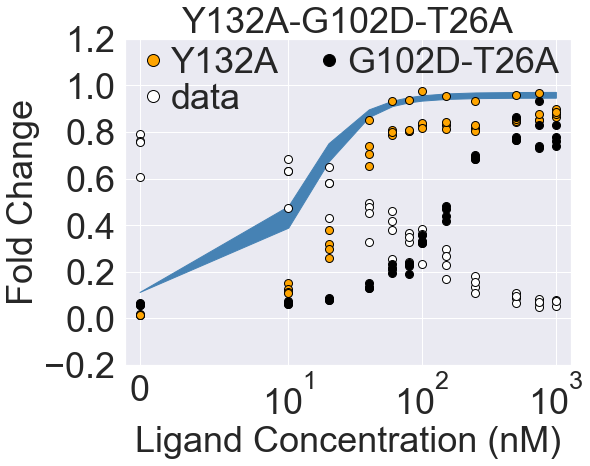

In [110]:
comb_mut(Post_Samples[0], Post_Samples[11], Parameters[0],Parameters[11], FCs_read[0],'Y132A', FCs_read[11],'G102D-T26A', FCs_read[-9], 'Y132A-G102D-T26A',[-0.05,0.72],1,1,1,1,1,1,2)


In [111]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [112]:
figlist_Fig4 = ['New_Figures/Y132A-G102D-T26A_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/Y132A-R49G_[1, 1, 0.5, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/Y132A-PIF_[1, 1, 0.5, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/Y132A-C203V_[1, 1, 0, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/C203V-R49G_[0, 1, 1, 1, 0, 1]_comb_FC_fit.png',
               'New_Figures/C203V-D53H_[0, 1, 1, 1, 0, 1]_comb_FC_fit.png',
               'New_Figures/C203V-G102D-L146A_[0, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/C203V-PIF_[0, 1, 1, 1, 1, 1]_comb_FC_fit.png']

print(len(figlist_Fig4))

8


In [120]:
images_Fig4 = [Image.open(x) for x in figlist_Fig4]
widths, heights = zip(*(i.size for i in images_Fig4))

total_width = (sum(widths[:4])+350)
max_height = (sum(heights[:2])+255)

Fig4 = Image.new('RGB', (total_width, max_height),color='white')
draw = ImageDraw.Draw(Fig4)
font = ImageFont.truetype('/Library/Fonts/Arial.ttf', size=250)

label=['A','B','C','D']
xu=-1
x_offset=50
for im in images_Fig4[:4]:
    xu+=1
    Fig4.paste(im, (x_offset, 50))
    draw.text((x_offset-50, 0), label[xu], font=font, fill='black')
    x_offset += (images_Fig4[0].size[0]+100)
    
label=['E','F','G','H']
xu=-1
x_offset=50
y_offset=heights[0]+250
for im in images_Fig4[4:]:
    xu+=1
    Fig4.paste(im, (x_offset, y_offset))
    draw.text((x_offset-50, y_offset-50), label[xu], font=font, fill='black')
    x_offset += (images_Fig4[0].size[0]+100)
    
Fig4.save('New_Figures/Fig4.png')
Fig4.save('New_Figures/Fig4.pdf')

In [121]:
figlist_FigS11 = ['New_Figures/Y132A-G102D-T26A_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/Y132A-R49G_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/Y132A-PIF_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/Y132A-C203V_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/C203V-R49G_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/C203V-D53H_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/C203V-G102D-L146A_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png',
               'New_Figures/C203V-PIF_[1, 1, 1, 1, 1, 1]_comb_FC_fit.png']

print(len(figlist_FigS11))

8


In [122]:
images_FigS11 = [Image.open(x) for x in figlist_FigS11]
widths, heights = zip(*(i.size for i in images_FigS11))

total_width = (sum(widths[:4])+350)
max_height = (sum(heights[:2])+255)

FigS11 = Image.new('RGB', (total_width, max_height),color='white')
draw = ImageDraw.Draw(FigS11)
font = ImageFont.truetype('/Library/Fonts/Arial.ttf', size=250)

label=['A','B','C','D']
xu=-1
x_offset=50
for im in images_FigS11[:4]:
    xu+=1
    FigS11.paste(im, (x_offset, 50))
    draw.text((x_offset-50, 0), label[xu], font=font, fill='black')
    x_offset += (images_FigS11[0].size[0]+100)
    
label=['E','F','G','H']
xu=-1
x_offset=50
y_offset=heights[0]+250
for im in images_FigS11[4:]:
    xu+=1
    FigS11.paste(im, (x_offset, y_offset))
    draw.text((x_offset-50, y_offset-50), label[xu], font=font, fill='black')
    x_offset += (images_FigS11[0].size[0]+100)
    
FigS11.save('New_Figures/FigS11.png')
FigS11.save('New_Figures/FigS11.pdf')